### Import modules

In [1]:
import pandas as pd
import json
import seaborn as sns
import datetime
import time
from matplotlib import pyplot as plt

### Loading dataset into dataframe

In [2]:
list_transactions = []
with open('transactions.txt') as fp:
    for line in fp:
        list_transactions.append(json.loads(line))

df = pd.DataFrame(list_transactions)

### Structure of the data

There are **786,363** records and **29** fields in the dataset.

In [3]:
#number of records and fields in the dataframe
print(df.shape)
print(df.columns)

(786363, 29)
Index(['accountNumber', 'accountOpenDate', 'acqCountry', 'availableMoney',
       'cardCVV', 'cardLast4Digits', 'cardPresent', 'creditLimit',
       'currentBalance', 'currentExpDate', 'customerId',
       'dateOfLastAddressChange', 'echoBuffer', 'enteredCVV',
       'expirationDateKeyInMatch', 'isFraud', 'merchantCategoryCode',
       'merchantCity', 'merchantCountryCode', 'merchantName', 'merchantState',
       'merchantZip', 'posConditionCode', 'posEntryMode', 'posOnPremises',
       'recurringAuthInd', 'transactionAmount', 'transactionDateTime',
       'transactionType'],
      dtype='object')


### Summary statistics
Lets see a quick statistic summary of the data

In [4]:
df.describe()

,availableMoney,creditLimit,currentBalance,transactionAmount
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,6250.725369,10759.464459,4508.739089,136.985791
std,8880.783989,11636.174890,6457.442068,147.725569
min,-1005.630000,250.000000,0.000000,0.000000
25%,1077.420000,5000.000000,689.910000,33.650000
50%,3184.860000,7500.000000,2451.760000,87.900000
75%,7500.000000,15000.000000,5291.095000,191.480000
max,50000.000000,50000.000000,47498.810000,2011.540000


Now list the unique values for each field in the dataframe as **(fieldname, number of unique values, unique values)**

In [5]:
for col in df:
    if col not in ['cardCVV', 'currentExpDate', 'enteredCVV']:
        print((col, df[col].nunique(), df[col].unique()))
        print()

('accountNumber', 5000, array(['737265056', '830329091', '574788567', ..., '899818521',
       '638498773', '732852505'], dtype=object))

('accountOpenDate', 1820, array(['2015-03-14', '2015-08-06', '2015-10-13', ..., '2009-08-17',
       '2008-04-15', '2012-08-23'], dtype=object))

('acqCountry', 5, array(['US', '', 'CAN', 'MEX', 'PR'], dtype=object))

('availableMoney', 521916, array([ 5000.  ,  4990.63,  4959.25, ..., 48766.15, 48716.72, 48666.83]))

('cardLast4Digits', 5246, array(['1803', '767', '3143', ..., '4635', '3783', '3388'], dtype=object))

('cardPresent', 2, array([False,  True]))

('creditLimit', 10, array([ 5000.,  2500., 50000., 15000., 10000.,   250.,   500.,  1000.,
        7500., 20000.]))

('currentBalance', 487318, array([   0.  ,    9.37,   40.75, ..., 1095.04, 1214.96, 1233.85]))

('customerId', 5000, array(['737265056', '830329091', '574788567', ..., '899818521',
       '638498773', '732852505'], dtype=object))

('dateOfLastAddressChange', 2184, array(['2015-03

The fields **echoBuffer, merchantCity, merchantState, merchantZip, posOnPremises, recurringAuthInd** contain **null value** only. We will drop these fields from the dataframe.

In [6]:
df.drop(columns=['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd' ], axis=1, inplace=True)

Lets now count **null values** for each of remaining fields.

In **acqCountry, merchantCountryCode, posConditionCode , posEntryMode, transactionType** fields there are 4562, 724, 409, 4054, 698 null values respectively.

In [7]:
for col in df:
    if df[col].dtype == 'object' and df[df[col] == ''].shape[0] > 0: #fields where data type is string
        print(col, df[df[col] == ''].shape[0])
    elif df[col].isna().sum() > 0:
        print(col, df[col].isna().sum())

acqCountry 4562
merchantCountryCode 724
posConditionCode 409
posEntryMode 4054
transactionType 698


### Histogram of the Processed Amounts of Each Transaction

The distribution of processed amounts of transactions is **right skewed**, that means it is not symmetric around the mean. The mean is greater than the median. Also notice that the tail of the distribution on the right hand (positive) side is longer than on the left hand side.

My hypothesis is customers use credit card mostly for small transactions.

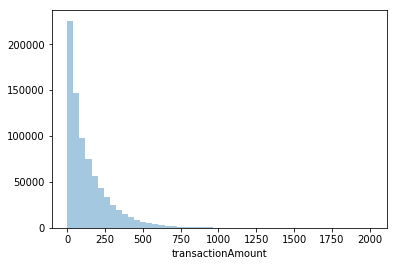

In [9]:
sns.distplot(df['transactionAmount'], hist = True, kde = False)
plt.show()

### Duplicate Transactions

First find the total count of duplicates that resulted from **reversed transactions**.

In [79]:
dfUniqueTransaction = df[['accountNumber', 'merchantName', 'transactionType', 'transactionAmount', 'transactionDateTime']]
dfPurchase = dfUniqueTransaction[df['transactionType'] == 'PURCHASE']
dfReversal = dfUniqueTransaction[df['transactionType'] == 'REVERSAL']

totalReversedDuplicates = 0
totalReversedDuplicatesAmount = 0

dfPurchaseSameAccount = None
prevAccountNumber = None

for _, row in dfReversal.iterrows():
    if row['accountNumber'] != prevAccountNumber:
        dfPurchaseSameAccount = dfPurchase[dfPurchase['accountNumber'] == row['accountNumber']]
        prevAccountNumber = row['accountNumber']
    if ((dfPurchaseSameAccount['transactionAmount'] == row['transactionAmount']) & (dfPurchaseSameAccount['merchantName'] == row['merchantName']) & (row['transactionDateTime'] > dfPurchaseSameAccount['transactionDateTime'])).any():
        totalReversedDuplicates += 1
        totalReversedDuplicatesAmount += row['transactionAmount']

print('Total number of reversal duplicates: ', totalReversedDuplicates)
print('Total dollar amount of reversal duplicates: $', totalReversedDuplicatesAmount)

Total number of reversal duplicates:  17759
Total dollar amount of reversal duplicates: $ 2666519.26999999


Now we will find total count of duplicates that resulted from **multiple swipes**.

In [80]:
dfUniqueTransaction = df[['accountNumber', 'merchantName', 'transactionType', 'transactionAmount', 'transactionDateTime']]
dfPurchase = dfUniqueTransaction[dfUniqueTransaction['transactionType'] == 'PURCHASE']
dfPurchase =dfPurchase.reset_index(drop=True)

totalMultiSwipeDuplicates = 0
totalMultiSwipeDuplicatesAmount = 0

lastSeenDuplicateTransaction = -1

for index1, row in dfPurchase.iterrows():
        
    if index1 < lastSeenDuplicateTransaction:
        continue
        
    for index2 in range(index1+1, dfPurchase.shape[0]):
        if row['accountNumber'] != dfPurchase.iloc[index2]['accountNumber']:
            break
        t1 = pd.to_datetime(row['transactionDateTime'])
        t2 = pd.to_datetime(dfPurchase.iloc[index2]['transactionDateTime'])
        
        
        if pd.Timedelta(t2 - t1).seconds > 300:
            break
                       
        if (row['merchantName'] == dfPurchase.iloc[index2]['merchantName']) and (row['transactionAmount'] == dfPurchase.iloc[index2]['transactionAmount']):
            totalMultiSwipeDuplicates += 1
            totalMultiSwipeDuplicatesAmount += row['transactionAmount']
            lastSeenDuplicateTransaction = index2    

print('Total number of multiple swipes duplicates: ', totalMultiSwipeDuplicates)
print('Total dollar amount of multiple swipes duplicates: $', totalMultiSwipeDuplicatesAmount)

Total number of multiple swipes duplicates:  7463
Total dollar amount of multiple swipes duplicates: $ 1103262.1899999934


In [65]:
df[310:340]

,accountNumber,accountOpenDate,acqCountry,availableMoney,cardCVV,cardLast4Digits,cardPresent,creditLimit,currentBalance,currentExpDate,...,expirationDateKeyInMatch,isFraud,merchantCategoryCode,merchantCountryCode,merchantName,posConditionCode,posEntryMode,transactionAmount,transactionDateTime,transactionType
310,984504651,2015-07-27,US,19485.33,640,8332,False,50000.0,30514.67,02/2030,...,False,False,online_retail,US,oldnavy.com,01,05,350.15,2016-03-29T08:33:24,PURCHASE
311,984504651,2015-07-27,US,19135.18,640,8332,False,50000.0,30864.82,06/2029,...,False,False,health,US,Walgreens #561782,01,09,199.25,2016-03-29T13:06:04,PURCHASE
312,984504651,2015-07-27,US,18935.93,640,8332,False,50000.0,31064.07,09/2024,...,False,False,health,US,Walgreens #854872,01,05,49.08,2016-03-29T21:58:59,PURCHASE
313,984504651,2015-07-27,US,18886.85,640,8332,False,50000.0,31113.15,06/2028,...,False,False,rideshare,US,Lyft,01,02,0.00,2016-03-30T11:43:18,ADDRESS_VERIFICATION
314,984504651,2015-07-27,US,18886.85,640,8332,True,50000.0,31113.15,04/2031,...,False,False,health,US,Golds Gym #512253,01,09,325.36,2016-03-31T18:12:27,PURCHASE
315,984504651,2015-07-27,US,18586.49,640,8332,True,50000.0,31413.51,07/2031,...,False,False,food,US,Franks Pub #934222,01,09,133.84,2016-04-01T10:04:27,PURCHASE
316,984504651,2015-07-27,US,18452.65,640,8332,False,50000.0,31547.35,12/2027,...,False,False,health,US,Planet Fitness #896201,01,80,102.86,2016-04-01T11:49:40,PURCHASE
317,984504651,2015-07-27,US,18349.79,640,8332,True,50000.0,31650.21,01/2022,...,False,False,health,US,WSC #208629,01,05,120.00,2016-04-01T23:07:02,PURCHASE
318,984504651,2015-07-27,US,18229.79,640,8332,False,50000.0,31770.21,12/2029,...,False,False,rideshare,US,Uber,01,09,56.52,2016-04-02T08:11:47,PURCHASE
319,984504651,2015-07-27,US,18173.27,640,8332,True,50000.0,31826.73,07/2029,...,False,False,food,US,Ray's Fries #61396,01,90,68.44,2016-04-02T16:23:47,PURCHASE
